# Data Limitations:

This Python Script merges the Index of Disparity (and subsequently the Index of Remoteness) with the complete census of Population File (completecensusprofile.csv) find the CSDs that drop out of the dataset.

Then, we find characteristics of the CSDs that fall out of the dataset:
- Average Population
- Median Population 
- Population Range

Then, we do the same with the Index of Remoteness analysis between Remoteness and Disparity Index:
- What is the average remoteness of CSDs that fall out in the merger


The implications are important: is there selection bias in the Dataset? If so, there may be a dropout of rural CSDs, which is the jurisdiction of interest. The CSDs with the most rurality may consequently be the ones with the least data, and perhaps the most economic disparity.


#### Note:

We use the Canadian relative datasets for this analysis, rather than provincial. This is an arbitrary selection. The sample size is the same for both, and the CSDs that drop out of the dataset because of missing data are the same. The only difference is the definition of percentiles.  

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from typing import Dict, List, Tuple
import math
import statistics
import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')      # Changes plot style.
%config InlineBackend.figure_format = 'retina' 

In [2]:
def most_recent_remoteness(export:bool):
    '''
    
    Returns a new CSV file with index of remoteness for 2011 and 2016 merged, 
    along with a value for the most recent index score (2016, otherwise 2011).
    
    
    If you want to export results to a CSV in the appropriate
    file, use True. Otherwise use False.
    
    '''
    
    os.chdir('/Users/DNW/Dropbox/Rural Data Project - RA/Remoteness Index - Raw')
    
    remindex = pd.read_csv('2016IR_DATABASE.csv',encoding='latin1')
    remindex = remindex.drop(columns=['ï»¿Pruid', 'CSDtype', 'CSDname', 'CSDpop2016', 'DGUID'])
    remindex.columns = ['csdcode','remoteness_index16']
    remindex = remindex.set_index('csdcode')
    remindex = remindex.replace('.', math.nan)
    
    remindex11 = pd.read_csv('2011IR_DATABASE.csv',encoding='latin1', header=1)
    remindex11.columns = ['csdcode', 'name', 'pop', 'trans1', 'trans2', 'agg', 'remoteness_index11']
    remindex11 = remindex11.drop(columns=['name', 'pop', 'trans1', 'trans2', 'agg'])
    remindex11.columns = ['csdcode','remoteness_index11']
    remindex11 = remindex11.set_index('csdcode')
    remindex11 = remindex11.replace('.', math.nan)
    
    lodexfull = []
    for i in remindex.index:
        lodexfull.append(i)
    
    for i in remindex11.index:
        if i not in lodexfull:
            lodexfull.append(i)
    
    newdf = pd.DataFrame(lodexfull)
    newdf['Null'] = math.nan
    newdf.columns=['csdcode', 'Null']
    newdf = newdf.set_index('csdcode')

    full_remindex = newdf.join(remindex11, on='csdcode')
    full_remindex = full_remindex.join(remindex, on='csdcode')
    full_remindex = full_remindex.drop(columns=['Null'])
    full_remindex = full_remindex.sort_values(by=['csdcode'])
    
    mostrecent = []
    for index, row in full_remindex.iterrows():
        rem11 = float(row['remoteness_index11'])
        rem16 = float(row['remoteness_index16'])
        if math.isnan(rem16) == False:
            mostrecent.append(rem16)
        elif math.isnan(rem16) == True:
            mostrecent.append(rem11)
    
    full_remindex['Most Recent Remoteness'] = mostrecent
    
    # Export new Dataset into Directory:
    if export == True:
        full_remindex.to_csv('Merged_Remoteness.csv', index='True')
        
    return 'New CSV Created'
    

In [3]:
most_recent_remoteness(True)

'New CSV Created'

In [4]:
def three_datasets(export:bool):
    '''
    Creates a merged dataframe of three datasets:
    - Complete Census Profile,
    - Index of Disparity
    - Index of Remoteness 2011 and 2016.
    '''
    
    os.chdir('/Users/DNW/Dropbox/Rural Data Project - RA/Census Data - Raw/Finished Census 2016-2001')
    census = pd.read_csv('20220918completecensusprofile.csv', encoding='latin1', low_memory=False)
    
    os.chdir('/Users/DNW/Dropbox/Rural Data Project - RA/Disparity Index - Analysis and Writeup/POST-REVISION OUTPUT/NationalCSVOutput')
    disparity = pd.read_csv('Disparity_Index_ca.csv')
    
    os.chdir('/Users/DNW/Dropbox/Rural Data Project - RA/Remoteness Index - Raw')
    remoteness = pd.read_csv('Merged_Remoteness.csv')
    
    census = census.set_index('csdcode')
    disparity = disparity.set_index('csdcode')
    remoteness = remoteness.set_index('csdcode')
    
    df = census.join(disparity, on='csdcode')
    df = df.join(remoteness, on='csdcode')

    return df

In [5]:
df = three_datasets(True)

# STEP 1 - FIND MOST RECENT POPULATION:
recentpop = []
for index, row in df.iterrows():
    rem = row['Most Recent Remoteness']
    pop96 = row['2001 2 Population and Dwelling Counts  Population in 1996']
    pop01 = row['2001 1 Population and Dwelling Counts Population in 2001']
    pop06 = row['2006 1 Population and dwelling counts Population in 2006']
    pop11 = row['2011 CEN1 Population and dwelling counts Population in 2011']
    pop16 = row['2016 1 id Population, 2016']
    
    # Find the most recent population of each CSD
    mostrecentpop = math.nan
    for pop in [pop16, pop11, pop06, pop01, pop96]:
        if type(pop) != str and math.isnan(pop) == False:
            mostrecentpop = pop
            break  
    recentpop.append(mostrecentpop)
    
df['Most Recent Population'] = recentpop

display(df)

,2016 Unnamed: 0,"2016 1 id Population, 2016",2016 10 id 0 to 4 years,2016 100 id Total - Knowledge of official languages for the total population excluding institutional residents - 100% data,"2016 1000 id Creole, n.o.s.","2016 1001 id Creole languages, n.i.e.",2016 1002 id Dravidian languages,2016 1003 id Kannada,2016 1004 id Malayalam,2016 1005 id Tamil,...,Population Disparity,Labour Disparity,Population Dependency,Industry Specialization,DisparityScore,Disparity Index,remoteness_index11,remoteness_index16,Most Recent Remoteness,Most Recent Population
csdcode,,,,,,,,,,,,,,,,,,,,,
4801003,0,7662,490,7645,0,0,0,0,0,0,...,0.076772,0.687807,0.541233,0.540742,0.461639,3.0,0.2971,0.2943,0.2943,7214.0
4801006,1,63260,3655,61975,10,0,120,0,100,45,...,0.076772,0.665914,0.317102,0.098763,0.289638,2.0,0.2939,0.2892,0.2892,60005.0
4801008,2,3581,355,3580,0,0,0,0,0,0,...,0.402710,0.483605,0.510505,0.394856,0.447919,3.0,0.3354,0.3287,0.3287,3336.0
4801009,3,541,40,540,0,0,0,0,0,0,...,0.517573,NaN,0.568035,0.759670,NaN,NaN,0.3670,0.3580,0.3580,526.0
4801014,4,1983,210,1870,0,0,0,0,0,0,...,0.258394,0.573925,0.296682,0.098763,0.306941,2.0,0.3402,0.3293,0.3293,2025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001055,31,411,25,410,0,0,0,0,0,0,...,0.338307,0.392107,0.195955,0.724622,0.412748,3.0,0.4648,0.4574,0.4574,346.0
6001057,32,0,x,x,x,x,x,x,x,x,...,NaN,NaN,NaN,NaN,NaN,NaN,0.5642,0.5507,0.5507,0.0
6001058,33,696,25,695,0,0,0,0,0,0,...,0.076772,0.049774,0.513450,0.392892,0.258222,2.0,0.4933,0.4853,0.4853,619.0


In [6]:
# STEP 2 - FIND THE CSDS THAT DROP OUT WHEN DISPARITY INDEX IS ADDED

dfDIS = df[df['Disparity Index'].isna()]
display(dfDIS)

,2016 Unnamed: 0,"2016 1 id Population, 2016",2016 10 id 0 to 4 years,2016 100 id Total - Knowledge of official languages for the total population excluding institutional residents - 100% data,"2016 1000 id Creole, n.o.s.","2016 1001 id Creole languages, n.i.e.",2016 1002 id Dravidian languages,2016 1003 id Kannada,2016 1004 id Malayalam,2016 1005 id Tamil,...,Population Disparity,Labour Disparity,Population Dependency,Industry Specialization,DisparityScore,Disparity Index,remoteness_index11,remoteness_index16,Most Recent Remoteness,Most Recent Population
csdcode,,,,,,,,,,,,,,,,,,,,,
4801009,3,541,40,540,0,0,0,0,0,0,...,0.517573,NaN,0.568035,0.759670,NaN,NaN,0.3670,0.3580,0.3580,526.0
4802004,8,827,25,805,0,0,0,0,0,0,...,0.692323,NaN,0.509130,0.604752,NaN,NaN,0.3476,0.3407,0.3407,811.0
4802009,11,978,80,980,0,0,0,0,0,0,...,0.283330,NaN,0.648930,0.643629,NaN,NaN,0.3014,0.2955,0.2955,1090.0
4802016,16,341,35,340,0,0,0,0,0,0,...,0.369527,NaN,0.197526,0.326134,NaN,NaN,0.2349,0.2236,0.2236,315.0
4803008,33,162,10,165,0,0,0,0,0,0,...,0.893972,NaN,0.819164,0.881210,NaN,NaN,0.3750,0.3646,0.3646,186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001046,25,0,x,x,x,x,x,x,x,x,...,0.684469,NaN,NaN,NaN,NaN,NaN,0.6013,0.5864,0.5864,0.0
6001047,26,10,x,x,x,x,x,x,x,x,...,0.199391,NaN,NaN,NaN,NaN,NaN,0.5419,0.5302,0.5302,15.0
6001049,28,55,0,50,0,0,0,0,0,0,...,0.181033,NaN,0.836049,0.438641,NaN,NaN,0.5875,0.5733,0.5733,35.0


In [7]:
# STEP 3 - FIND THE CSDS THAT DROP OUT WHEN REMOTENESS INDEX IS ADDED

dfREM = df[df['Most Recent Remoteness'].isna()]
display(dfREM)

,2016 Unnamed: 0,"2016 1 id Population, 2016",2016 10 id 0 to 4 years,2016 100 id Total - Knowledge of official languages for the total population excluding institutional residents - 100% data,"2016 1000 id Creole, n.o.s.","2016 1001 id Creole languages, n.i.e.",2016 1002 id Dravidian languages,2016 1003 id Kannada,2016 1004 id Malayalam,2016 1005 id Tamil,...,Population Disparity,Labour Disparity,Population Dependency,Industry Specialization,DisparityScore,Disparity Index,remoteness_index11,remoteness_index16,Most Recent Remoteness,Most Recent Population
csdcode,,,,,,,,,,,,,,,,,,,,,
5941862,553,0,x,x,x,x,x,x,x,x,...,0.487041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5959809,735,0,x,x,x,x,x,x,x,x,...,0.487041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6205033,22,0,x,x,x,x,x,x,x,x,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6208065,25,0,x,x,x,x,x,x,x,x,...,0.684469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6102063,14,0,x,x,x,x,x,x,x,x,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6103097,19,0,x,x,x,x,x,x,x,x,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3560081,557,0,x,x,x,x,x,x,x,x,...,0.487041,0.049774,0.055468,0.432751,0.256259,2.0,NaN,NaN,NaN,0.0
3560102,573,0,x,x,x,x,x,x,x,x,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1010042,362,0,x,x,x,x,x,x,x,x,...,0.487041,0.049774,0.055468,0.376792,0.242269,2.0,NaN,NaN,NaN,0.0


In [8]:
# STEP 4 - FIND THE CSDS THAT DROP OUT WHEN BOTH ARE ADDED

dfLIM = df.filter(['Most Recent Remoteness', 'Disparity Index', 'Most Recent Population'])
dfLIM['CSD'] = dfLIM.index

csdict = {}
for index, row in dfLIM.iterrows():
    rem = row['Most Recent Remoteness']
    dis = row['Disparity Index']
    pop = row['Most Recent Population']
    csd = row['CSD']
    
    if math.isnan(rem) or math.isnan(dis):
        csdict[csd] = pop

dfLIM = pd.DataFrame.from_dict(csdict, orient='index', columns=['Most Recent Population'])
dfLIM

,Most Recent Population
4801009.0,526.0
4802004.0,811.0
4802009.0,1090.0
4802016.0,315.0
4803008.0,186.0
...,...
6001046.0,0.0
6001047.0,15.0
6001049.0,35.0
6001052.0,28.0


In [11]:
# STEP 5:

# A) AVG POP OF CSDS LOST IN DIS INDEX

avgDISp = dfDIS['Most Recent Population'].mean()
print('Average Population of CSDs lost in Disparity Index: ', avgDISp)
medDISp = dfDIS['Most Recent Population'].median()
print('Median Population of CSDs lost in Disparity Index: ', medDISp)

# B) AVG REM OF CSDS LOST IN DIS INDEX

avgDISr = dfDIS['Most Recent Remoteness'].mean()
print('Average Remoteness of CSDs lost in Disparity Index: ', avgDISr)
medDISr = dfDIS['Most Recent Remoteness'].median()
print('Median Remoteness of CSDs lost in Disparity Index: ', medDISr)

# C) AVG POP OF CSDS LOST IN REM INDEX

avgREMp = dfREM['Most Recent Population'].mean()
print('Average Population of CSDs lost in Remoteness Index: ', avgREMp)
medREMp = dfREM['Most Recent Population'].median()
print('Median Population of CSDs lost in Disparity Index: ', medREMp)

# D) AVG POP OF CSDS LOST IN BOTH

avgLIMp = dfLIM['Most Recent Population'].mean()
print('Average Population of CSDs lost after including both Disparity and Remoteness Index: ', avgLIMp)

medLIMp = dfLIM['Most Recent Population'].median()
print('Median Population of CSDs lost after including both Disparity and Remoteness Index: ', medLIMp)

Average Population of CSDs lost in Disparity Index:  142.39815668202766
Median Population of CSDs lost in Disparity Index:  46.0
Average Remoteness of CSDs lost in Disparity Index:  0.4041530516431922
Median Remoteness of CSDs lost in Disparity Index:  0.3664
Average Population of CSDs lost in Remoteness Index:  0.0
Median Population of CSDs lost in Disparity Index:  0.0
Average Population of CSDs lost after including both Disparity and Remoteness Index:  142.13615455381785
Median Population of CSDs lost after including both Disparity and Remoteness Index:  46.0


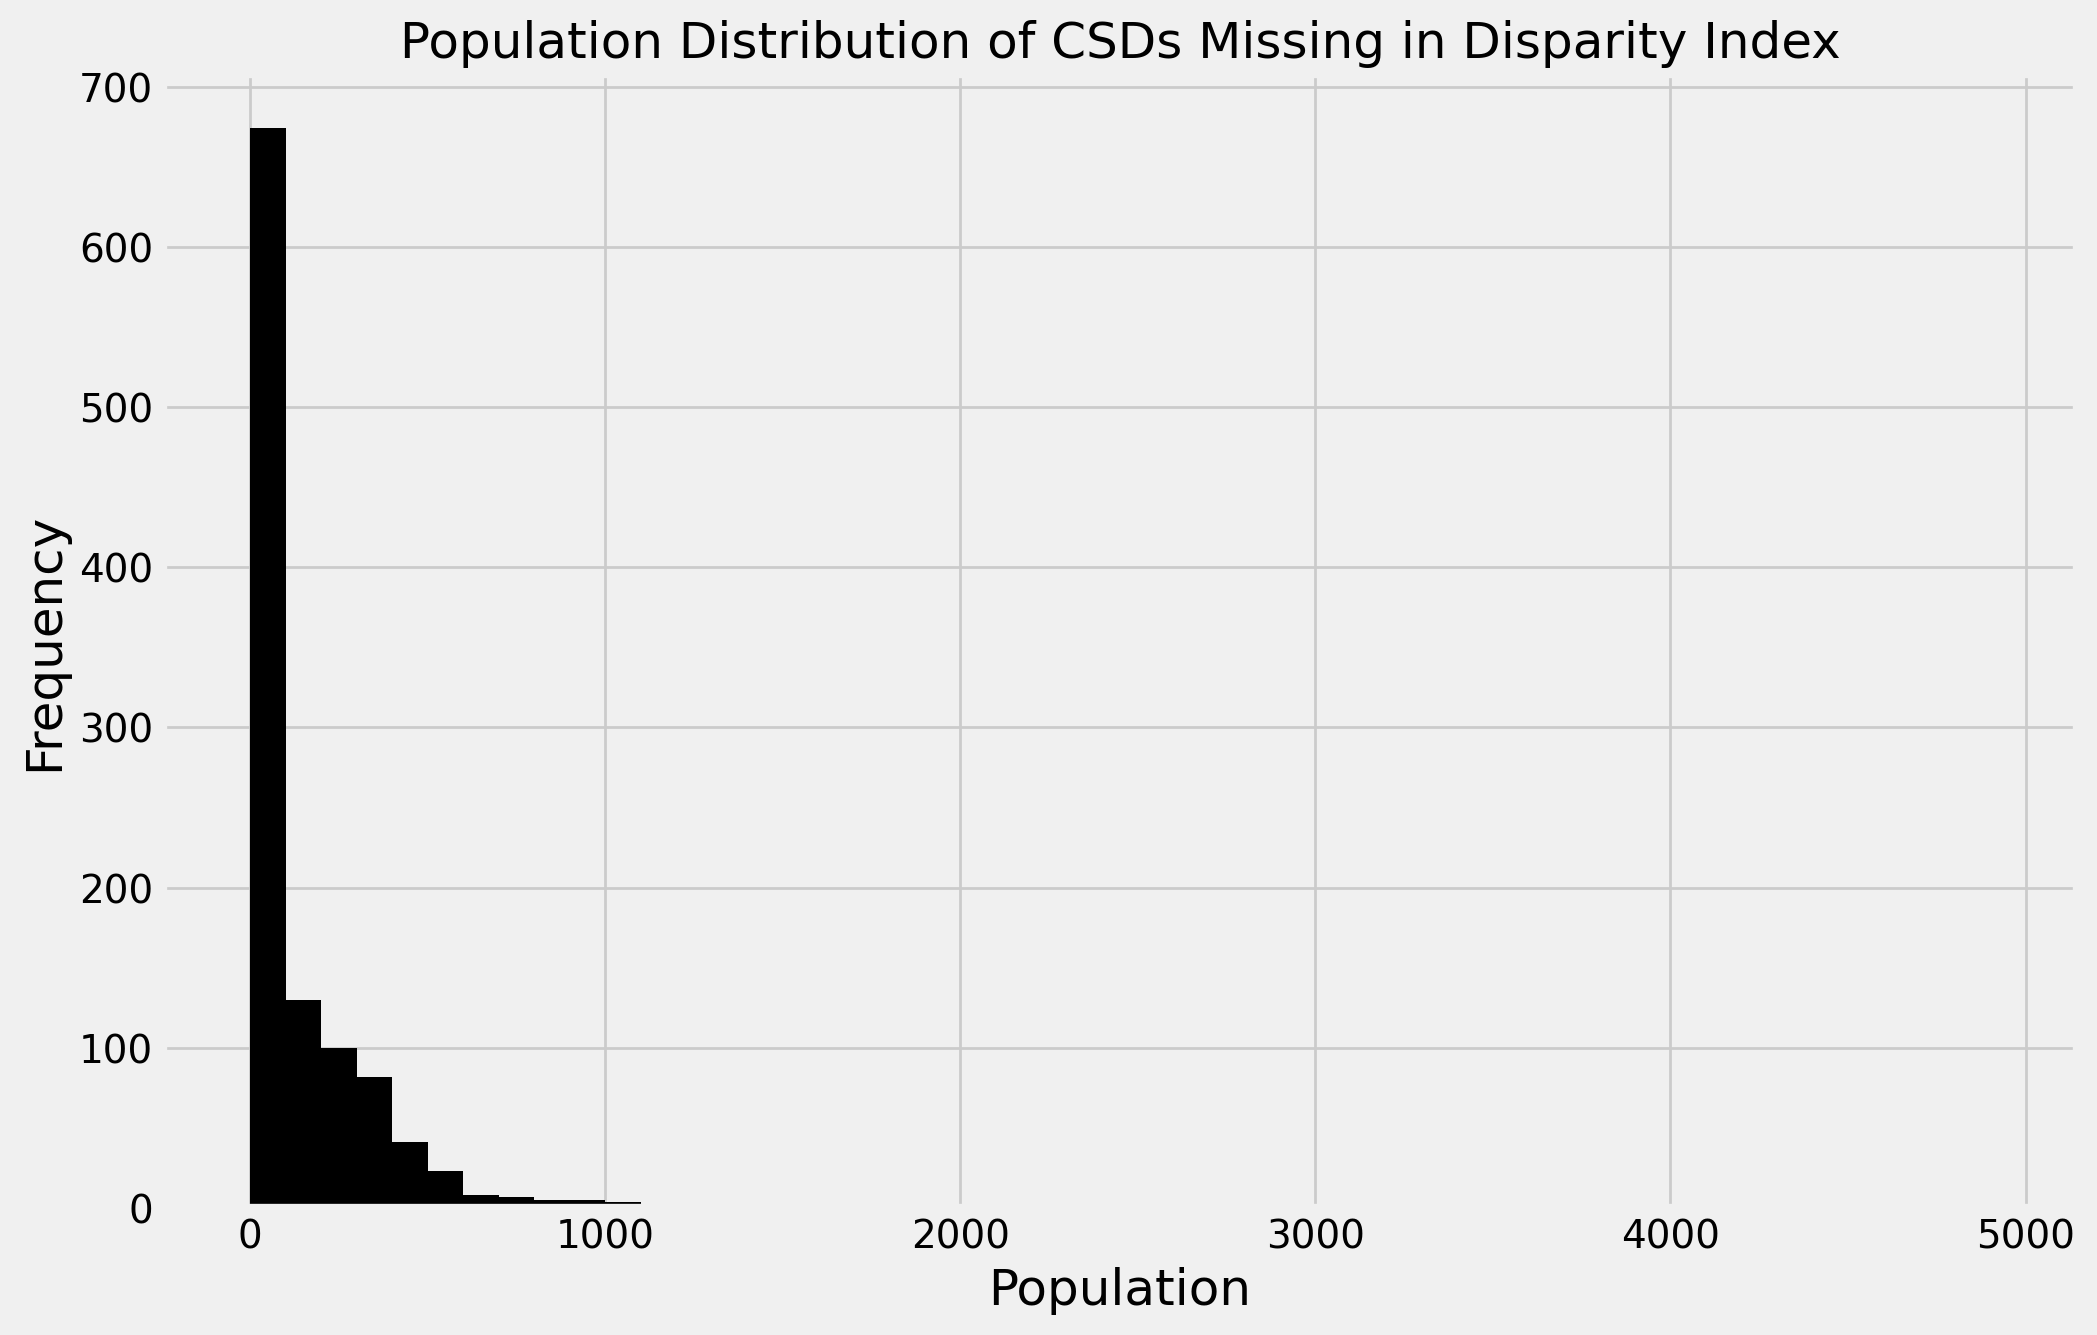

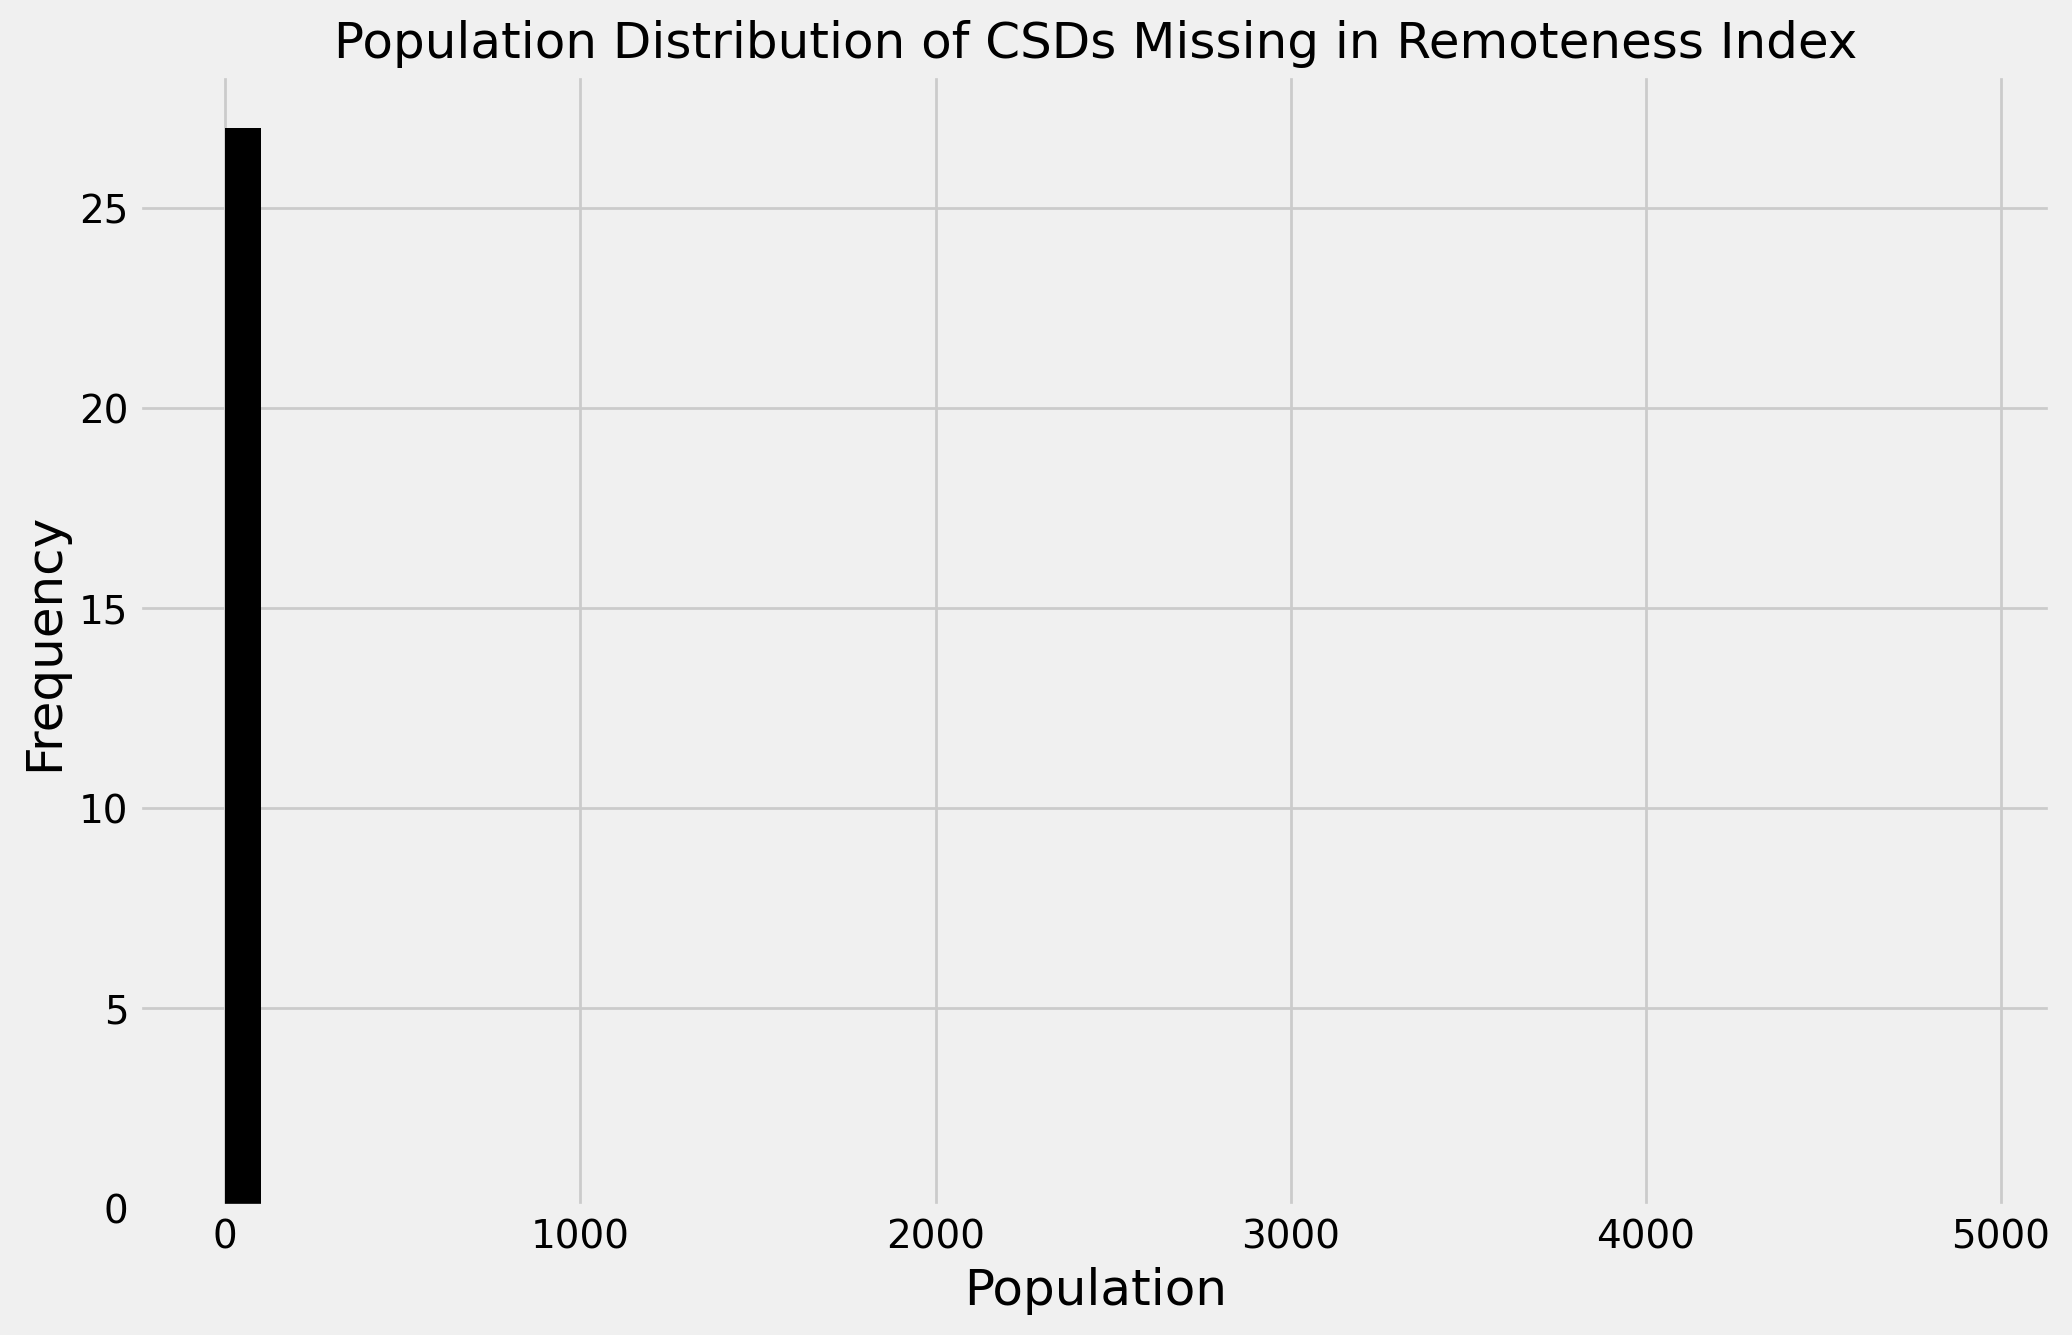

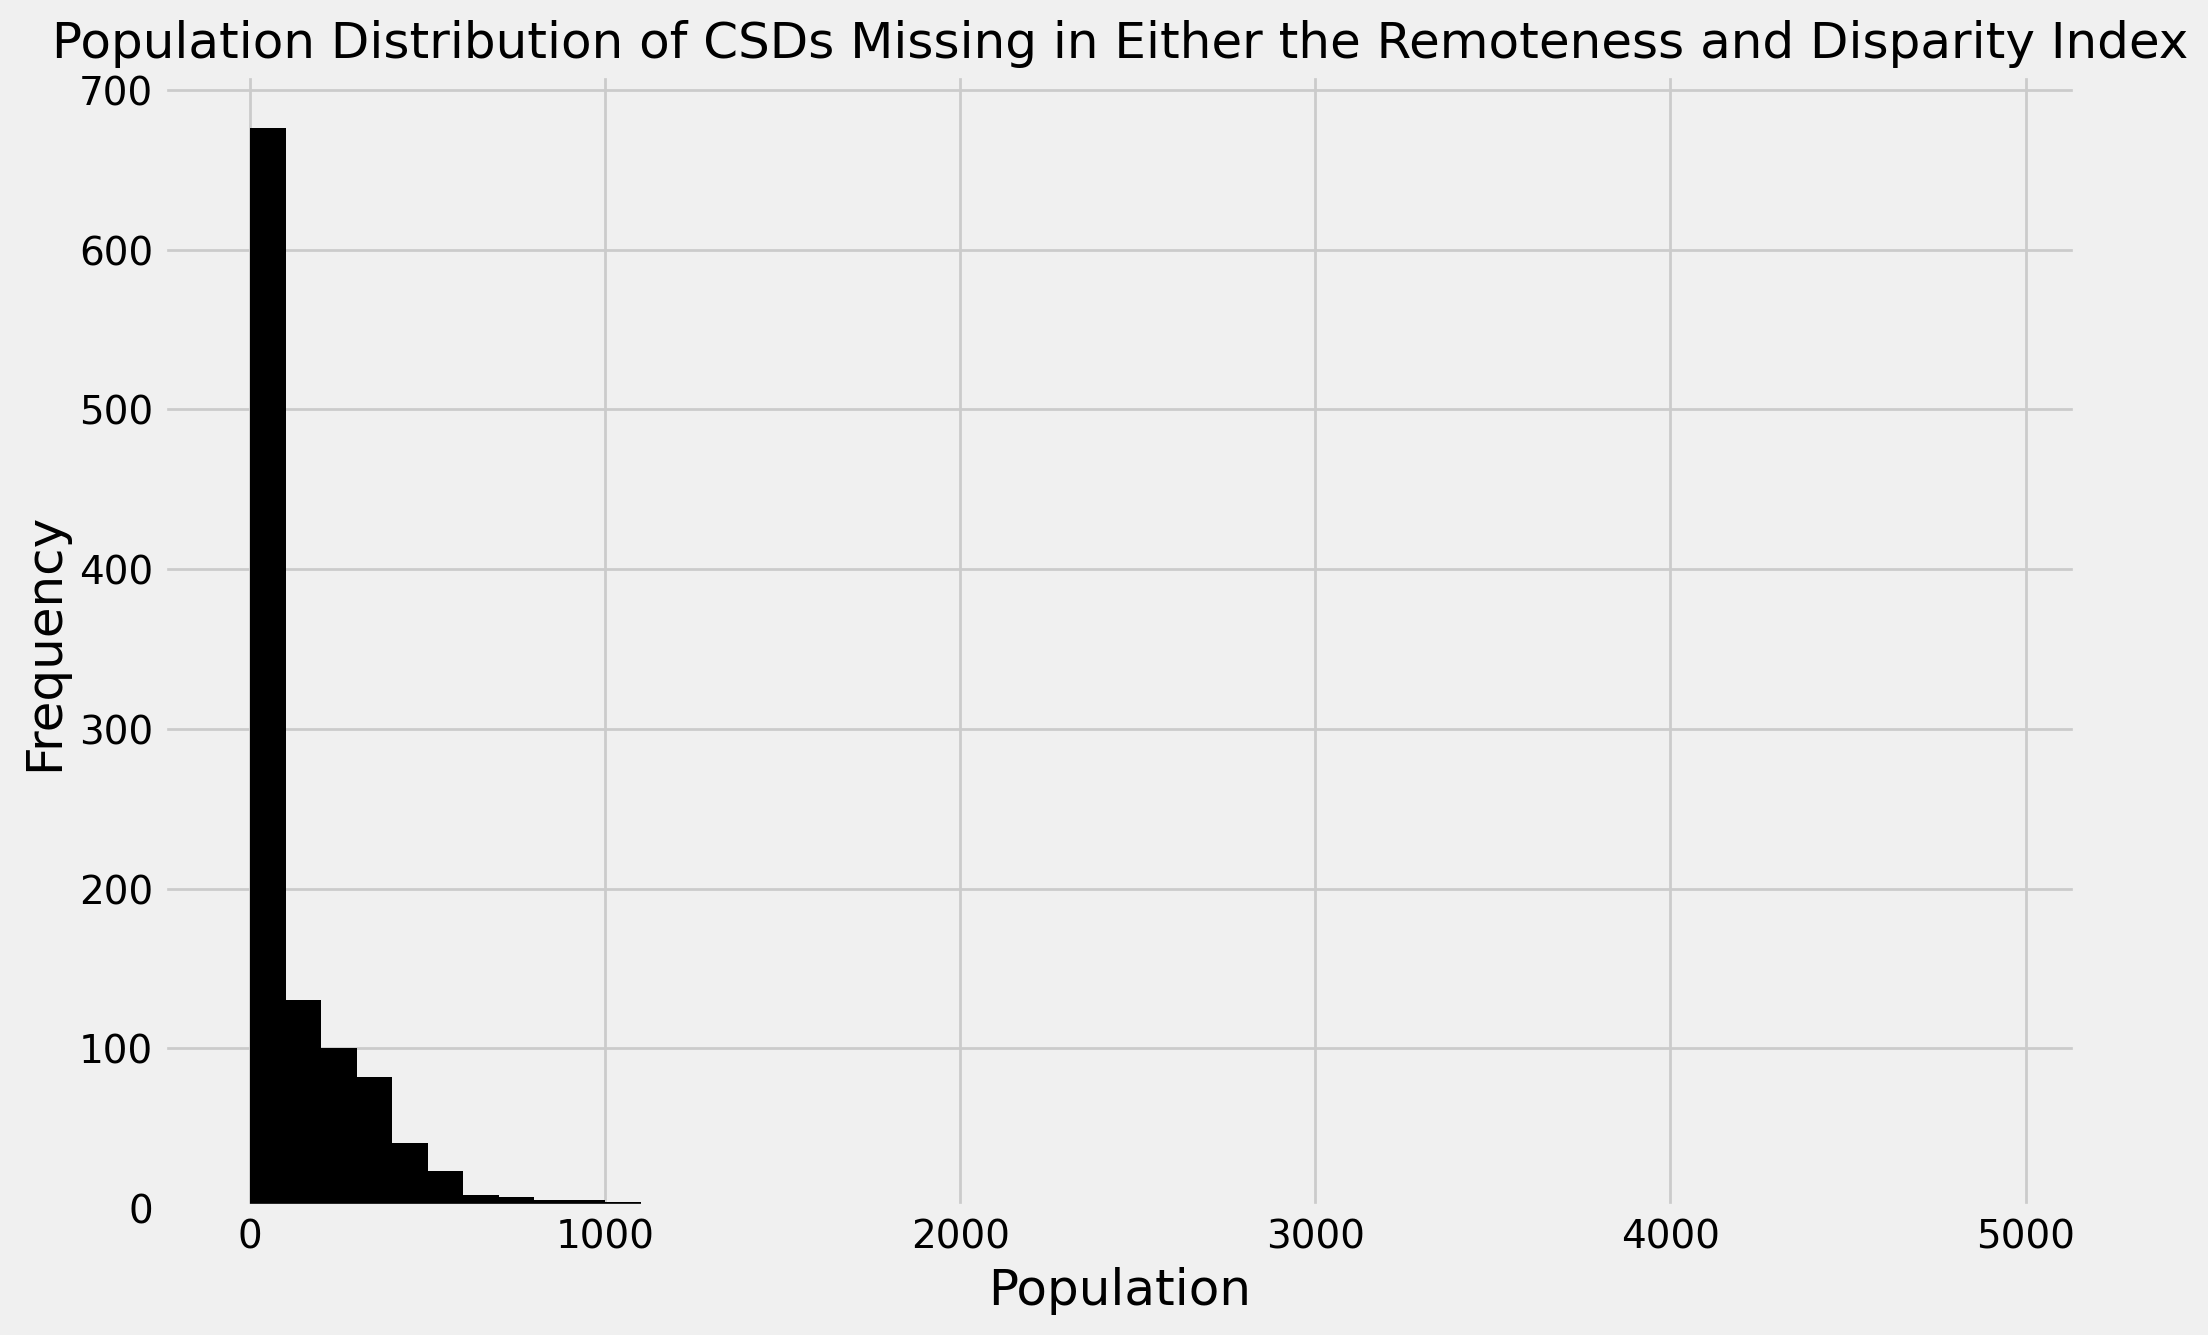

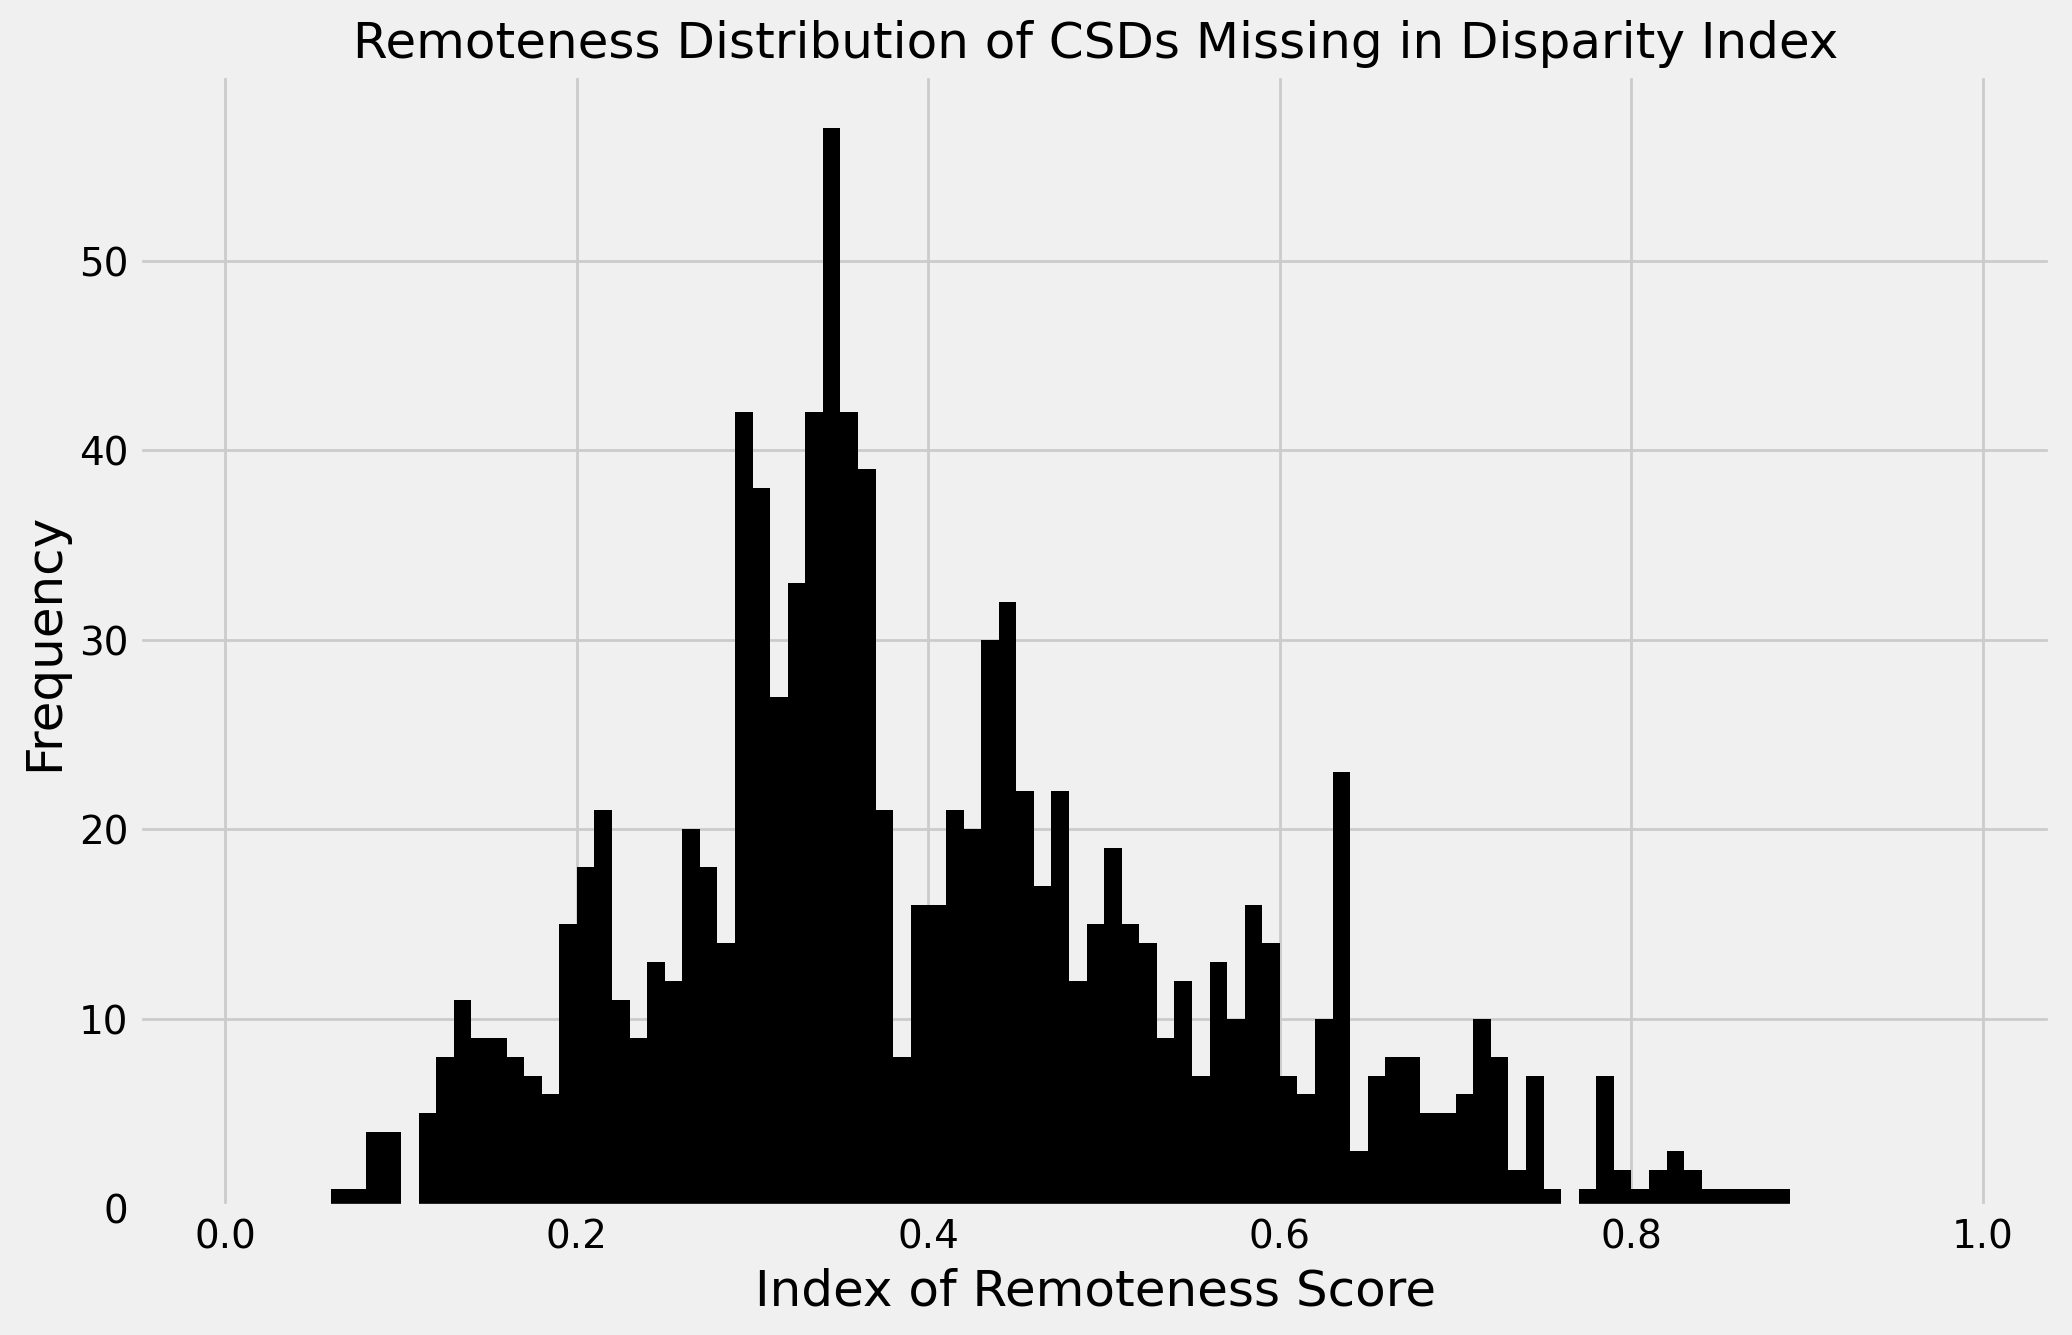

In [10]:
# STEP 6: DISTRIBUTION PLOTS:


# A) POP OF CSDS LOST IN DIS INDEX

bin_edges = np.arange(0, 5000, 100)

fig1, ax1 = plt.subplots(figsize=(11,7))
ax1.hist(dfDIS['Most Recent Population'], bins=bin_edges, color='black', label='Data')
ax1.set_title('Population Distribution of CSDs Missing in Disparity Index', fontsize=18)
ax1.set_ylabel('Frequency', fontsize=18)
ax1.set_xlabel('Population', fontsize=18)
rects = ax1.patches

plt.show()


# B) POP OF CSDS LOST IN REM INDEX

bin_edges = np.arange(0, 5000, 100)

fig2, ax1 = plt.subplots(figsize=(11,7))
ax1.hist(dfREM['Most Recent Population'], bins=bin_edges, color='black', label='Data')
ax1.set_title('Population Distribution of CSDs Missing in Remoteness Index', fontsize=18)
ax1.set_ylabel('Frequency', fontsize=18)
ax1.set_xlabel('Population', fontsize=18)
rects = ax1.patches

plt.show()

# C) POP OF CSDS LOST IN BOTH

bin_edges = np.arange(0, 5000, 100)

fig3, ax1 = plt.subplots(figsize=(11,7))
ax1.hist(dfLIM['Most Recent Population'], bins=bin_edges, color='black', label='Data')
ax1.set_title('Population Distribution of CSDs Missing in Either the Remoteness and Disparity Index', fontsize=18)
ax1.set_ylabel('Frequency', fontsize=18)
ax1.set_xlabel('Population', fontsize=18)
rects = ax1.patches

plt.show()

# D) REM OF CSDS LOST IN DIS INDEX

bin_edges = np.arange(0, 1, 0.01)

fig3, ax1 = plt.subplots(figsize=(11,7))
ax1.hist(dfDIS['Most Recent Remoteness'], bins = bin_edges, color='black', label='Data')
ax1.set_title('Remoteness Distribution of CSDs Missing in Disparity Index', fontsize=18)
ax1.set_ylabel('Frequency', fontsize=18)
ax1.set_xlabel('Index of Remoteness Score', fontsize=18)
rects = ax1.patches

plt.show()



